# Table of Content #

- [Importing Necessary Libraries](#Importing-Necessary-Libraries)
- [Importing Data and Initial Checks](#Importing-Data-and-Initial-Checks)
- [Pre-Processing](#Pre-Processing)
- [Baseline Model](#Baseline-Model)

## Importing Necessary Libraries ##

In [36]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.pipeline                import Pipeline
from sklearn.model_selection         import train_test_split, GridSearchCV
from sklearn.linear_model            import LogisticRegression
from sklearn.ensemble                import BaggingClassifier,RandomForestClassifier,ExtraTreesClassifier,AdaBoostClassifier,GradientBoostingClassifier

from sklearn.tree                    import DecisionTreeClassifier
from sklearn.svm                     import SVC

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

## Importing Data and Initial Checks ##

In [37]:
#Loading data from a csv file
data = pd.read_csv('~/ga/projects/capstone_data/data/data_model.csv')

#Checking size
data.shape

(1777932, 25)

In [38]:
#Checking columns
data.columns

Index(['Unnamed: 0', 'month', 'day_of_month', 'day_of_week', 'fl_date',
       'op_carrier', 'op_carrier_fl_num', 'origin', 'origin_city_name',
       'origin_state_abr', 'origin_state_nm', 'dest', 'dest_city_name',
       'dest_state_abr', 'dest_state_nm', 'dep_delay', 'arr_delay', 'distance',
       'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay', 'carrier', 'total_delay'],
      dtype='object')

In [56]:
#Dropping a technical column
data.drop(columns = ['Unnamed: 0'], axis=1, inplace=True)

KeyError: "['Unnamed: 0'] not found in axis"

## Pre-Processing

In order to prepare our dataset for modeling we need to know what features are heavily correlated with our target value.

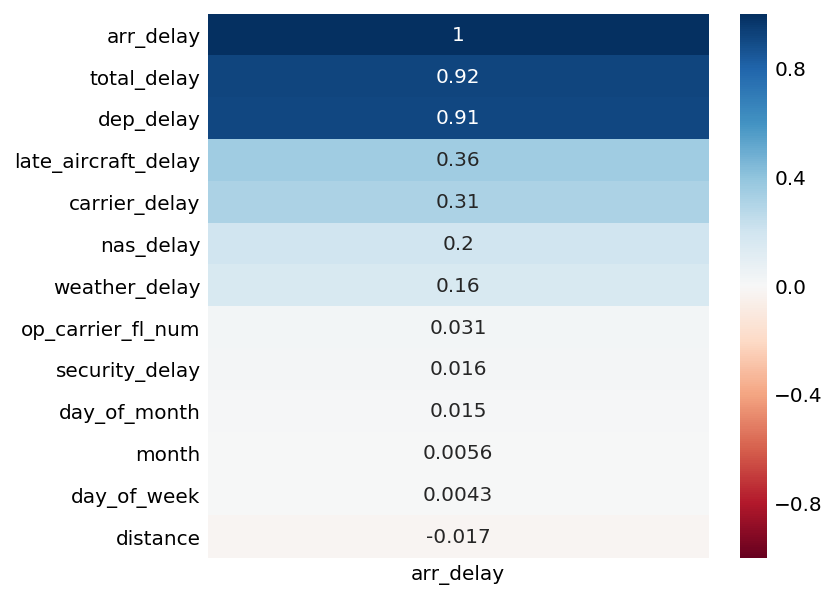

In [40]:
#Correlation heatmap to our target ARR_DELAY column
plt.figure(figsize = (5,5))
sns.heatmap(data.corr()[['arr_delay']].sort_values('arr_delay',ascending=False), 
            annot=True, 
            cmap = 'RdBu', 
            vmin = -1, vmax = 1);  

Looking at the correlation heatmap, one can notice a number of features that are heavily correlated to our target value:

* TOTAL_DELAY - which is an **explained** part of ARRIVAL_DELAY 
* DEP_DELAY
* LATE_AIRCRAFT_DELAY
* CARRIER_DELAY
* NAS_DELAY
* WEATHER_DELAY
* SECURITY_DELAY

These are integral parts of resulting delay on arrival and we could not use them for predicting the delay.

In [41]:
#Getting a list of delay column names
delay_columns = [column for column in data.columns if column.endswith('_delay')]

#Removing our target valuable 
delay_columns.remove('arr_delay')

#Dropping the delay_columns from the modeling dataset
data.drop(columns=delay_columns,axis=1,inplace=True)

In [42]:
#A look at our target 
data['arr_delay'].value_counts()

-10.0      52837
-9.0       52496
-11.0      52347
-8.0       52265
-7.0       51452
           ...  
 1112.0        1
 1576.0        1
 1556.0        1
 1008.0        1
 1213.0        1
Name: arr_delay, Length: 1325, dtype: int64

In [43]:
data['arr_delay'].describe()

count    1.777932e+06
mean     4.276324e+00
std      4.741508e+01
min     -7.400000e+01
25%     -1.400000e+01
50%     -6.000000e+00
75%      7.000000e+00
max      2.153000e+03
Name: arr_delay, dtype: float64

A discreet variable with a range between -7 and 2153, close to 2_000_000 values is not the best target variable for logistic regression. Let's engineer a categorical variable DELAY_INDICATOR with the foloowing binary values:
* 0 - if ARRIVAL_DELAY is **less than 15 minutes** which corresponds with the industry standard when a "true delay" is considered to have happened and get reported accoringly when a flight arrives at a gate or disembarkation position 15 or more minutes later then scheduled
* 1 - if ARRIVAL_DELAY is **15 minutes or more - "true delay"**

In [44]:
#Introducing DELAY_INDICATOR column as our target
data['delay_indicator'] = np.where(data['arr_delay']>14,1,0)

## Baseline Model ##

In order to establish a basis for comparison, we need to set our baseline model and evaluation method. For classification models in our situation it is natural to opt for **accuracy** as we care for the accuracy of our predictions most, while sencitivity/specificity metrics and Type I/II errors are not of paramount importace. 

In [45]:
#Getting initial baseline accuracy
data['delay_indicator'].value_counts(normalize=True)

0    0.817047
1    0.182953
Name: delay_indicator, dtype: float64

In order to avoid inbalanced clasees with our future classification models we need to address this problem by constructing our modeling dataset in a way our positive and negative classes are balanced as 1:1. Hence, we will randomly pull tweets out of our positive class - and a number of these tweets will be equal to the number of tweets in our negative class. 

In [46]:
#Creating auxillary DataFrames with positive and negative classes and balancing the classes
data_negative = data[data['delay_indicator'] == 1]
data_pozitive = data[data['delay_indicator'] == 0].sample(data_negative.shape[0])

#Creating a balanced dataset for modeling
data_balanced = pd.concat([data_pozitive,data_negative])

#Checking the size of balanced dataset
data_balanced.shape

(650556, 18)

In [49]:
#Checking dataframe
data_balanced.head()

,month,day_of_month,day_of_week,fl_date,op_carrier,op_carrier_fl_num,origin,origin_city_name,origin_state_abr,origin_state_nm,dest,dest_city_name,dest_state_abr,dest_state_nm,arr_delay,distance,carrier,delay_indicator
1138724,11,29,4,2018-11-29,OO,3539,GEG,"Spokane, WA",WA,Washington,SLC,"Salt Lake City, UT",UT,Utah,-13.0,546.0,Delta,0
1010919,11,3,6,2018-11-03,OO,3614,TPA,"Tampa, FL",FL,Florida,RDU,"Raleigh/Durham, NC",NC,North Carolina,-14.0,587.0,Delta,0
1636351,12,19,3,2018-12-19,WN,3013,LAX,"Los Angeles, CA",CA,California,PDX,"Portland, OR",OR,Oregon,-3.0,834.0,SouthWest,0
922779,11,1,4,2018-11-01,YX,3557,IAH,"Houston, TX",TX,Texas,CVG,"Cincinnati, OH",KY,Kentucky,-13.0,871.0,American,0
1334601,12,11,2,2018-12-11,OO,4903,IAH,"Houston, TX",TX,Texas,DTW,"Detroit, MI",MI,Michigan,-19.0,1075.0,Delta,0


In [51]:
#Checking data types
data_balanced.dtypes

month                  int64
day_of_month           int64
day_of_week            int64
fl_date               object
op_carrier            object
op_carrier_fl_num      int64
origin                object
origin_city_name      object
origin_state_abr      object
origin_state_nm       object
dest                  object
dest_city_name        object
dest_state_abr        object
dest_state_nm         object
arr_delay            float64
distance             float64
carrier               object
delay_indicator        int64
dtype: object

In [52]:
#Dropping columns with irrelevant/doubled information
data_balanced.drop(columns=['fl_date',
                           'op_carrier',
                           'origin_city_name',
                           'origin_state_abr',
                           'origin_state_nm',
                           'dest_city_name',
                           'dest_state_abr',
                           'dest_state_nm'], axis=1, inplace=True)

In [55]:
#Saving our pre-processed dataset to a csv file
data_balanced.to_csv('~/ga/projects/capstone_data/data/data_ready.csv')

In [13]:
delay_columns.append('delay_indicator')
y = data_balanced['delay_indicator']
X = data_balanced.drop(columns=delay_columns, axis=1)
X

,month,day_of_month,day_of_week,fl_date,op_carrier,op_carrier_fl_num,origin,origin_city_name,origin_state_abr,origin_state_nm,dest,dest_city_name,dest_state_abr,dest_state_nm,distance,carrier
68344,10,30,2,2018-10-30,B6,489,BOS,"Boston, MA",MA,Massachusetts,DCA,"Washington, DC",VA,Virginia,399.0,JetBlue
1494726,12,16,7,2018-12-16,NK,197,LGA,"New York, NY",NY,New York,FLL,"Fort Lauderdale, FL",FL,Florida,1076.0,Spirit Airlines
1033004,11,24,6,2018-11-24,UA,2317,MSY,"New Orleans, LA",LA,Louisiana,IAH,"Houston, TX",TX,Texas,305.0,United
190101,10,18,4,2018-10-18,AA,2445,MIA,"Miami, FL",FL,Florida,DEN,"Denver, CO",CO,Colorado,1709.0,American
50239,10,26,5,2018-10-26,OH,5283,PVD,"Providence, RI",RI,Rhode Island,CLT,"Charlotte, NC",NC,North Carolina,683.0,American
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1777896,12,29,6,2018-12-29,YV,6003,OKC,"Oklahoma City, OK",OK,Oklahoma,DFW,"Dallas/Fort Worth, TX",TX,Texas,175.0,American
1777900,12,2,7,2018-12-02,YV,6003,PHX,"Phoenix, AZ",AZ,Arizona,OKC,"Oklahoma City, OK",OK,Oklahoma,833.0,American
1777911,12,13,4,2018-12-13,YV,6003,PHX,"Phoenix, AZ",AZ,Arizona,OKC,"Oklahoma City, OK",OK,Oklahoma,833.0,American
1777924,12,26,3,2018-12-26,YV,6003,PHX,"Phoenix, AZ",AZ,Arizona,OKC,"Oklahoma City, OK",OK,Oklahoma,833.0,American


In [14]:
type(X)

pandas.core.frame.DataFrame

In [15]:
X.dtypes

month                  int64
day_of_month           int64
day_of_week            int64
fl_date               object
op_carrier            object
op_carrier_fl_num      int64
origin                object
origin_city_name      object
origin_state_abr      object
origin_state_nm       object
dest                  object
dest_city_name        object
dest_state_abr        object
dest_state_nm         object
distance             float64
carrier               object
dtype: object

In [16]:
y.shape

(650556,)

In [17]:
y.mean()

0.5

In [18]:
X = pd.get_dummies(X,columns = ['origin','dest','carrier'],drop_first=True )

In [19]:
X.head()

,month,day_of_month,day_of_week,fl_date,op_carrier,op_carrier_fl_num,origin_city_name,origin_state_abr,origin_state_nm,dest_city_name,...,dest_YUM,carrier_Allegiant Air,carrier_American,carrier_Delta,carrier_Frontier Airlines,carrier_Hawaiian Airlines,carrier_JetBlue,carrier_SouthWest,carrier_Spirit Airlines,carrier_United
68344,10,30,2,2018-10-30,B6,489,"Boston, MA",MA,Massachusetts,"Washington, DC",...,0,0,0,0,0,0,1,0,0,0
1494726,12,16,7,2018-12-16,NK,197,"New York, NY",NY,New York,"Fort Lauderdale, FL",...,0,0,0,0,0,0,0,0,1,0
1033004,11,24,6,2018-11-24,UA,2317,"New Orleans, LA",LA,Louisiana,"Houston, TX",...,0,0,0,0,0,0,0,0,0,1
190101,10,18,4,2018-10-18,AA,2445,"Miami, FL",FL,Florida,"Denver, CO",...,0,0,1,0,0,0,0,0,0,0
50239,10,26,5,2018-10-26,OH,5283,"Providence, RI",RI,Rhode Island,"Charlotte, NC",...,0,0,1,0,0,0,0,0,0,0


In [20]:
X.shape

(650556, 720)

In [21]:
X = X._get_numeric_data()
X.shape

(650556, 712)

## Logistic Regression##

In [22]:
lr = LogisticRegression()

In [23]:
X.shape

(650556, 712)

In [24]:
y.shape

(650556,)

In [25]:
y.value_counts(normalize=True)

1    0.5
0    0.5
Name: delay_indicator, dtype: float64

In [26]:
#Training and testing sets split with stratification 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [27]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
lr.score(X_train,y_train)

0.5743005470192676

In [29]:
lr.score(X_test, y_test)

0.5706072959130344

In [30]:
y_hat = lr.predict(X_test)

In [31]:
from sklearn.metrics import mean_squared_error as mse

In [32]:
mse(y_hat, y_test)

0.4293927040869656

In [33]:
coefs = lr.coef_

In [34]:
cd = pd.DataFrame(coefs).T

In [35]:
cd.describe()

,0
count,712.000000
mean,-0.002321
std,0.113469
min,-0.402318
25%,-0.044939
50%,-0.006448
75%,0.029017
max,0.777358


In [36]:
cd.head()

,0
0,0.069260
1,0.004106
2,0.006410
3,0.000077
4,0.000012


In [37]:
cd.columns = ['coef']

In [38]:
cd.head()

,coef
0,0.069260
1,0.004106
2,0.006410
3,0.000077
4,0.000012


In [45]:
cd[abs(cd['coef']) > .5]

,coef
115,0.589843
245,0.523541
464,0.777358
544,0.502358
706,0.687725


In [40]:
cd2 = list(cd[abs(cd['coef'])>1].index)
cd2

[]

In [41]:
X.columns[cd2]

Index([], dtype='object')

In [42]:
cd1 = list(cd[abs(cd['coef'])<.1].index)
cd1

[0,
 1,
 2,
 3,
 4,
 5,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 21,
 22,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 59,
 60,
 61,
 63,
 64,
 65,
 66,
 69,
 70,
 71,
 72,
 73,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 91,
 92,
 93,
 94,
 96,
 97,
 98,
 99,
 102,
 103,
 104,
 105,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 116,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 126,
 127,
 128,
 129,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 152,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 164,
 166,
 167,
 168,
 169,
 170,
 171,
 173,
 176,
 177,
 178,
 179,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 209,
 211,
 212,
 215,
 216,
 220,
 221,
 222,
 223,
 224,
 225,
 227,
 228,
 

In [43]:
set(X.columns)-set(X.columns[cd1])

{'carrier_Allegiant Air',
 'carrier_American',
 'carrier_Delta',
 'carrier_Frontier Airlines',
 'carrier_JetBlue',
 'carrier_Spirit Airlines',
 'dest_ASE',
 'dest_AZA',
 'dest_BOS',
 'dest_BUF',
 'dest_BWI',
 'dest_CAK',
 'dest_CHS',
 'dest_CLE',
 'dest_CLT',
 'dest_CMH',
 'dest_COS',
 'dest_CRP',
 'dest_CVG',
 'dest_DAL',
 'dest_DAY',
 'dest_DEN',
 'dest_DFW',
 'dest_DTW',
 'dest_ECP',
 'dest_EGE',
 'dest_EWR',
 'dest_EYW',
 'dest_FLL',
 'dest_FSD',
 'dest_GEG',
 'dest_GJT',
 'dest_GRB',
 'dest_HNL',
 'dest_HOU',
 'dest_HPN',
 'dest_IAH',
 'dest_ILM',
 'dest_ITO',
 'dest_JFK',
 'dest_KOA',
 'dest_LEX',
 'dest_LGA',
 'dest_LGB',
 'dest_LIH',
 'dest_MAF',
 'dest_MCI',
 'dest_MCO',
 'dest_MHT',
 'dest_MIA',
 'dest_MSN',
 'dest_MSP',
 'dest_MSY',
 'dest_MYR',
 'dest_OGG',
 'dest_ORD',
 'dest_PBI',
 'dest_PDX',
 'dest_PIA',
 'dest_PIT',
 'dest_PSP',
 'dest_SAT',
 'dest_SEA',
 'dest_SFB',
 'dest_SFO',
 'dest_SJU',
 'dest_SLC',
 'dest_SMF',
 'dest_TLH',
 'dest_VPS',
 'origin_ABQ',
 'origin_A

In [44]:
X.columns

Index(['month', 'day_of_month', 'day_of_week', 'op_carrier_fl_num', 'distance',
       'origin_ABI', 'origin_ABQ', 'origin_ABR', 'origin_ABY', 'origin_ACK',
       ...
       'dest_YUM', 'carrier_Allegiant Air', 'carrier_American',
       'carrier_Delta', 'carrier_Frontier Airlines',
       'carrier_Hawaiian Airlines', 'carrier_JetBlue', 'carrier_SouthWest',
       'carrier_Spirit Airlines', 'carrier_United'],
      dtype='object', length=712)